<a href="https://www.kaggle.com/code/ardaorcun/transfer-learning-breast-cancer-detection?scriptVersionId=127595285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Recently, artificial intelligence (AI) has also been widely employed in the field of healthcare. Particularly, AI has contributed to medical diagnosis in radiology by convolutional neural network (CNN). CNN has a great capacity to classify images such as X-ray images by way of supervised learning. It is expected that AI may facilitate the quality of healthcare services and reduce workloads for healthcare professionals.

In [1]:
!pip3 install ann_visualizer
!pip3 install graphviz

  Preparing metadata (setup.py) ... - done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=f6836c7cdfe3546bb05ec330929bccfb0bc849c9ff51a2866cac75460f0796b1
  Stored in directory: /root/.cache/pip/wheels/9d/fb/fa/cc002927ad0327942fc1eba45ce3bedd1e128c6d5c21f1d851
Successfully built ann_visualizer


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import cv2
import os 
from tqdm.keras import TqdmCallback
from ann_visualizer.visualize import ann_viz
import shutil
import glob
from glob import glob

import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model, model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Reading Files and Defining Constants

In [3]:
RSNA_512_path='/kaggle/input/rsna-breast-cancer-512-pngs'


In [4]:
df_train=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head(3)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False


*A Reminder*

**Mammography typically involves capturing two views of the breast from different angles because the location of breast cancer can vary. While breast cancer is most commonly found in the upper outer quadrant of the breast, the breast's shape remains relatively constant across different views. Additionally, the left and right breasts usually have a similar view. Therefore, for the purpose of machine learning, we can overlook the laterality and view of the breast.**

For the training data set, patients with breast implants can be excluded as the patient in the test data set does not have an implant. Furthermore, the absence of an implant means there is no risk of false positive cancer detection due to the implant. While it is unclear whether other patients in the hidden test data set have implants, generally few patients have them, indicating that implants have minimal impact on this machine learning process.

In [5]:
'''Number of patients'''
len(df_train)

54706

In [6]:
'''Number of patients having implemant'''
len(df_train[df_train['implant'] == 1])


1477

In [7]:
'''Number of patients without malign cancer'''
len(df_train[df_train['cancer'] == 0])


53548

In [8]:
'''Number of patients with malign cancer'''
len(df_train[df_train['cancer'] == 1])


1158

In [9]:
'''Number of patients who took biopsy'''
len(df_train[df_train['biopsy'] == 1])


2969

In [10]:
'''Number of patients whose malign cancer is invasive'''
len(df_train[df_train['invasive'] == 1])


818

<AxesSubplot:xlabel='class', ylabel='count'>

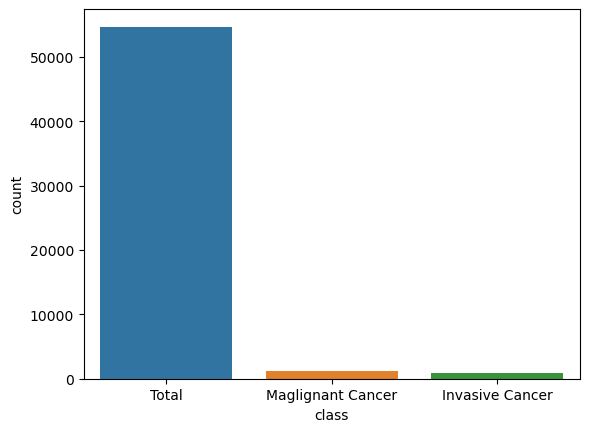

In [11]:
'''Most of the cases are normal or not-malignant cancer. Thus, physicians sometimes overlook cancer.'''
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])
sns.countplot(x='class', data=data)

<AxesSubplot:xlabel='class', ylabel='count'>

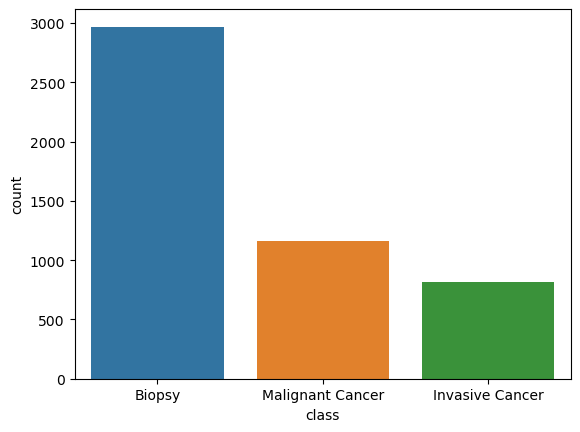

In [12]:
'''Around 3000 patient took biopsy and malignant cancer was found from some of them.'''
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [13]:
'''the number of not-malignant cancer cases from biopsy'''
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])


1811

In [14]:
'the number of malignant cancer cases from biopsy'
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])


1158

<AxesSubplot:xlabel='class', ylabel='count'>

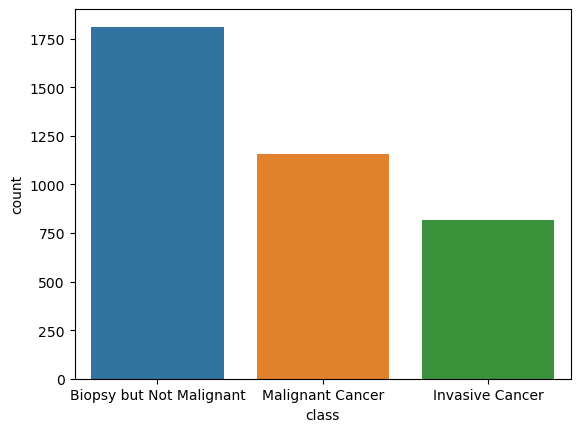

In [15]:
'60% of biopsy resulted in not-malignanct cancer.'
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

Determining which cases of "not-malignant cancer" to select for analysis is a complex matter. The selection can be made from (1) the whole population of patients without malignant cancer, (2) the entire population of patients who have not undergone biopsy, or (3) patients who have undergone biopsy but do not have malignant cancer.

The first choice is ideal for initial screening purposes for the general population, most of whom are healthy.

Patients typically undergo biopsy due to clinical findings or family history, in addition to the detection of suspicious mammography images of breast cancer. Therefore, images from "patients with biopsy but without malignant cancer" may show perfectly healthy patients, benign tumors, or other non-cancerous conditions like inflammation. Thus, the second choice may be best if the initial screening aims to detect only malignant breast cancer, and patients are not suspected of having any other diseases.

The third choice is ideal for special screenings where there is a suspicion of malignant cancer in a patient. This method is particularly useful when a patient is suspected of having malignant cancer and the AI can be used before a biopsy is conducted.

In [16]:
'The not-malignant cancer cases were limited into biopsy cases.'
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head(3)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True


In [17]:
''' The number of positive (malignant) and negative (not-malignat) cases should be the same
to create a balanced dataset.'''
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

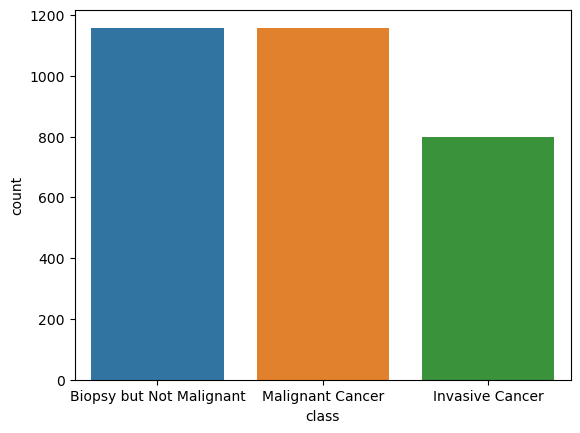

In [18]:
'Generally, invasive cancer is confirmed by biopsy, not by mammography.'
'Maybe it is also extremely difficult for AI to detect invasive cancer from mammography.'
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

# Creating Path for Each Image

In [19]:
for i in range(len(DF_train)):
    DF_train.loc[i, 'path'] = os.path.join(RSNA_512_path + '/' + str(DF_train.loc[i, 'patient_id']) + '_' + str(DF_train.loc[i, 'image_id']) + '.png')
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,29756,1460513750,L,MLO,56.0,0,1,0,0.0,0,B,170,True,/kaggle/input/rsna-breast-cancer-512-pngs/2975...
1,1,12064,1464744279,L,MLO,68.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1206...
2,2,36366,1100135117,R,MLO,54.0,0,1,0,NaN,0,NaN,29,True,/kaggle/input/rsna-breast-cancer-512-pngs/3636...
3,1,36438,1189865220,L,CC,42.0,0,1,0,0.0,1,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3643...
4,1,561,1543867548,L,MLO,53.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/561_...


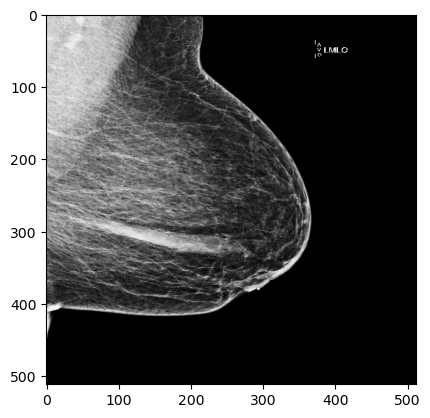

In [20]:
img=cv2.imread(DF_train.loc[0, 'path'])
plt.imshow(img, cmap='gray')

In [21]:
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[106, 106, 106],
        [ 99,  99,  99],
        [108, 108, 108],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[201, 201, 201],
        [199, 199, 199],
        [205, 205, 205],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[250, 250, 250],
        [ 46,  46,  46],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[124, 124, 124],
        [ 17,  17,  17],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [22]:
img.shape

(512, 512, 3)

# Setting Up Train and Validation Set

In [23]:
train_df, val_df= train_test_split(
    DF_train,
    test_size=0.3, 
    random_state=2023,
    stratify=DF_train['cancer']
)

print(f"Train:{train_df.shape[0]} Validation: {val_df.shape[0]}")
print(f"Train: {train_df['cancer'].value_counts()}")
print(f"Validation: {val_df['cancer'].value_counts()}")

Train:1621 Validation: 695
Train: 0    811
1    810
Name: cancer, dtype: int64
Validation: 1    348
0    347
Name: cancer, dtype: int64


In [24]:
train_df.sample(1)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
1795,1,10226,530620473,L,CC,71.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/1022...


In [25]:
'Picking up normal images from data'
train_df_normal=train_df[train_df['cancer']==0].reset_index(drop=True)
print(len(train_df_normal))
train_df_normal.head(3)

811


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,49552,1865012183,R,CC,66.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4955...
1,1,21765,1090520916,L,MLO,57.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/2176...
2,1,32072,148002834,L,CC,48.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/3207...


In [26]:
'Picking up cancer images from data'
train_df_cancer=train_df[train_df['cancer']==1].reset_index(drop=True)
print(len(train_df_cancer))
train_df_cancer.head(3)

810


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,61490,1035631534,R,MLO,53.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/6149...
1,1,3626,293937906,L,MLO,82.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3626...
2,2,60033,1168039233,L,CC,57.0,1,1,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/6003...


In [27]:
'Picking up normal images from data'
val_df_normal=val_df[val_df['cancer']==0].reset_index(drop=True)
print(len(val_df_normal))
val_df_normal.head(3)

347


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,60534,487534890,L,MLO,64.0,0,1,0,0.0,0,B,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/6053...
1,1,12033,1002679701,L,MLO,42.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/1203...
2,1,48320,2029959789,R,CC,48.0,0,1,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-512-pngs/4832...


In [28]:
'Pick up cancer images from the validation data.'
val_df_cancer = val_df[val_df['cancer'] == 1].reset_index(drop = True)
print(len(val_df_cancer))
val_df_cancer.head()

348


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,44225,774155798,R,CC,60.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/4422...
1,2,39355,685765674,L,CC,67.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-512-pngs/3935...
2,2,60442,787281164,L,MLO,52.0,1,1,1,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-512-pngs/6044...
3,1,31582,564250417,L,CC,72.0,1,1,0,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-512-pngs/3158...
4,2,32668,1646575508,R,MLO,62.0,1,1,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-512-pngs/3266...


In [29]:
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/normal'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)
    
for path in train_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [30]:
destination_dir = '/kaggle/working/train'
destination_dir_sub = '/kaggle/working/train/cancer'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
for path in train_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [31]:
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/normal'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
for path in val_df_normal['path']:
    shutil.copy2(path, destination_dir_sub)

In [32]:
destination_dir = '/kaggle/working/val'
destination_dir_sub = '/kaggle/working/val/cancer'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

if not os.path.exists(destination_dir_sub):
    os.makedirs(destination_dir_sub)   
    
for path in val_df_cancer['path']:
    shutil.copy2(path, destination_dir_sub)

In [33]:
import glob
normal_train_images = glob.glob('/kaggle/working/train/normal/*.png')
cancer_train_images = glob.glob('/kaggle/working/train/cancer/*.png')

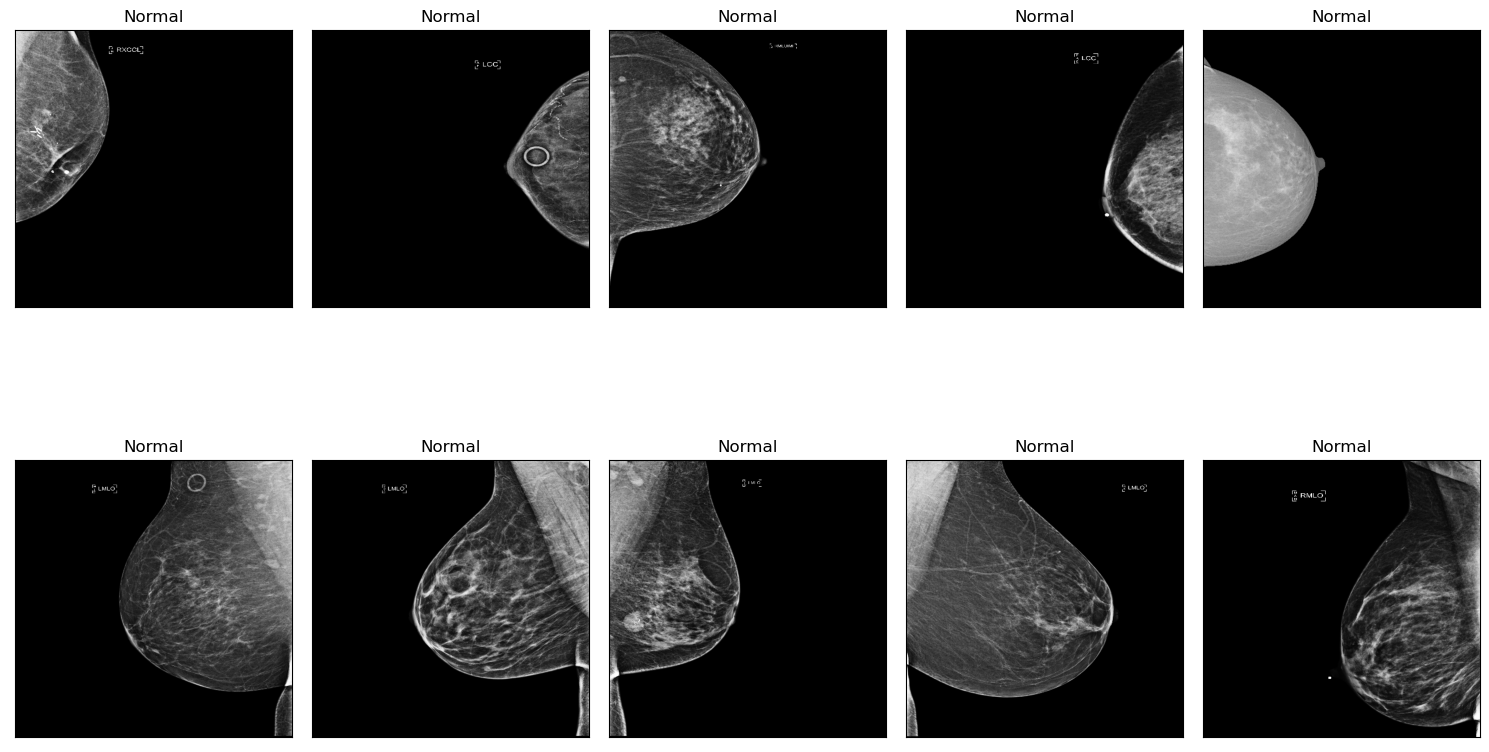

In [34]:
fig, axes= plt.subplots(nrows=2, ncols=5, figsize=(15,10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img=cv2.imread(normal_train_images[i])
    ax.imshow(img)
    ax.set_title('Normal')
fig.tight_layout()

plt.show()

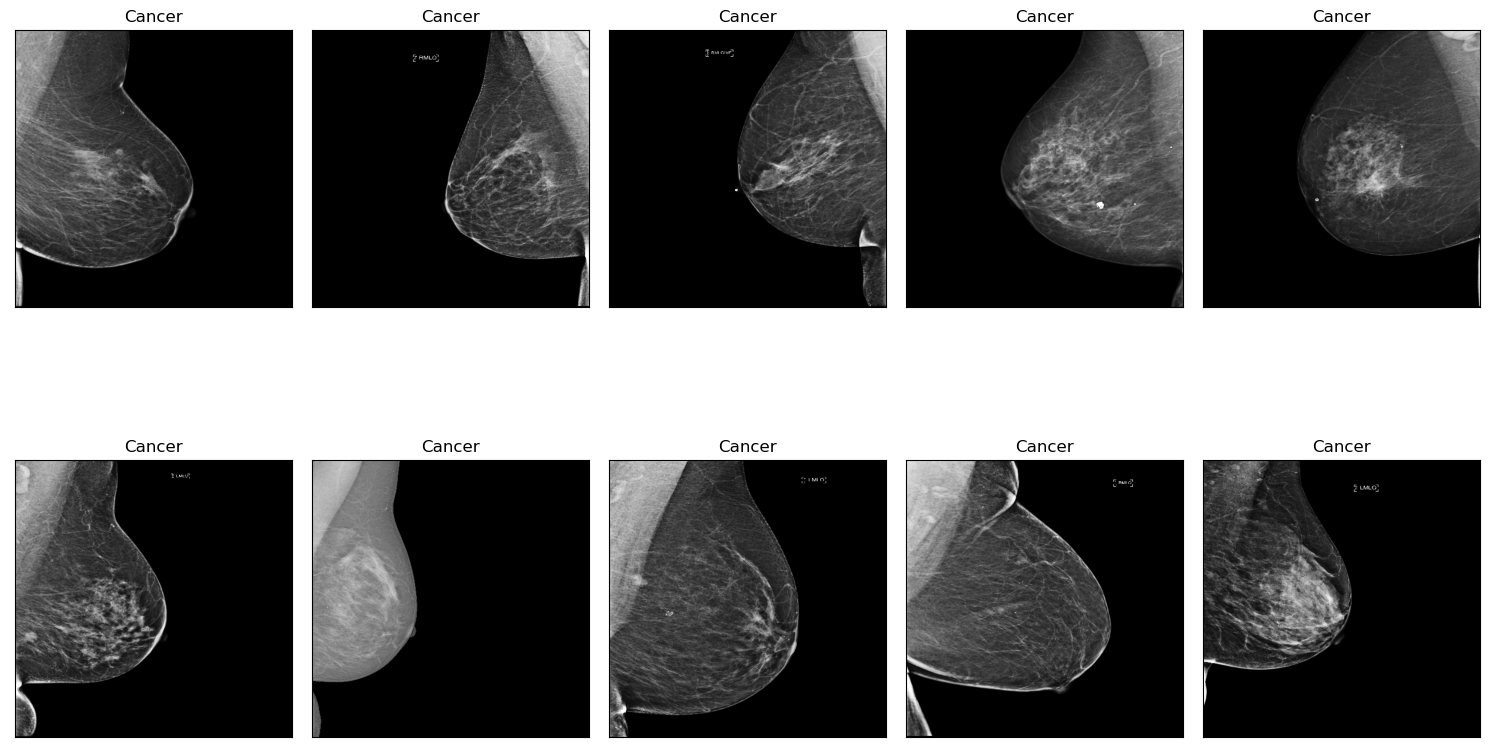

In [35]:
fig, axes= plt.subplots(nrows=2, ncols=5, figsize=(15,10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img=cv2.imread(cancer_train_images[i])
    ax.imshow(img)
    ax.set_title('Cancer')
fig.tight_layout()

plt.show()

# Creating Image Data Generators

In [36]:
train_datagen=ImageDataGenerator(rescale=1./255., zoom_range=0.2)
val_datagen=ImageDataGenerator(rescale=1./255.) 

In [37]:
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=(512,512),
    batch_size=32,
    class_mode='binary'
)
validation_generator=val_datagen.flow_from_directory(
    val_path,
    target_size=(512,512),
    batch_size=32,
    class_mode='binary'
)

Found 1250 images belonging to 2 classes.
Found 625 images belonging to 2 classes.


# Defining Model ResNet50v2
In this study, ResNet50V2 was chosen as the base model for transfer learning. Fine-tuning of the model is also a possibility, and the choice of hyperparameters depends on the specific machine learning task at hand. For this study, the final activation function, optimizer, and loss function were chosen as sigmoid, Adam, and binary cross-entropy, respectively.

In [38]:
base_model=ResNet50V2(weights='imagenet', input_shape=(512,512,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
    
model= Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94668760/94668760 [==============================] - 1s 0us/step


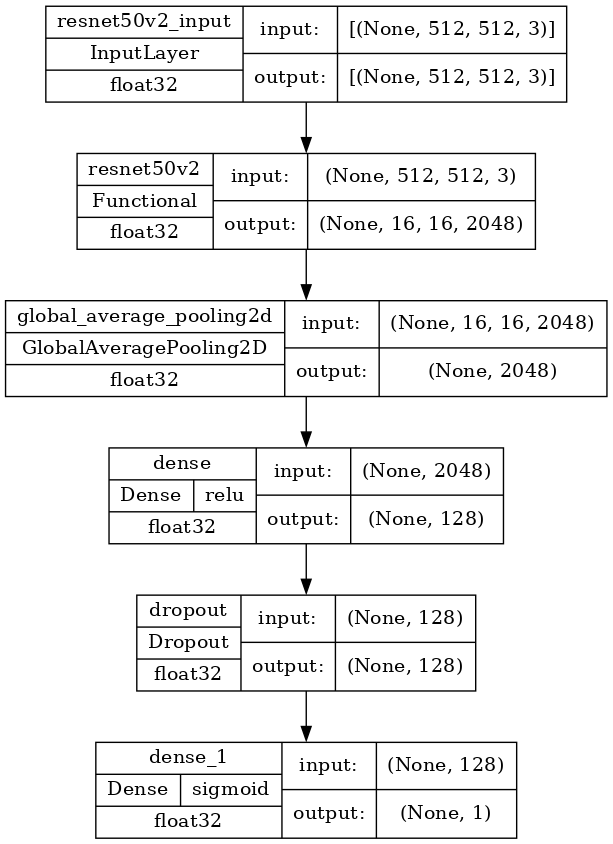

In [39]:
plot_model(model, show_dtype=True, show_layer_activations=True, show_shapes=True, show_layer_names=True,
          to_file='model.png', dpi=100)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

# Training the Model
The model was trained using both the train and validation datasets, and early stopping was incorporated to prevent overfitting. However, in some cases, it may be beneficial to increase the number of epochs used in training the model.

In [41]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=4)

In [42]:
history=model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=20,
    epochs=40,
    verbose=0,
    callbacks=[callback, TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

In [43]:
model.save('model.h5')

# Model Metrics

In [44]:
accuracy=history.history['accuracy']
loss=history.history['loss']
val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']


# Visualizing Accuracy and Loss

Text(0, 0.5, 'loss')

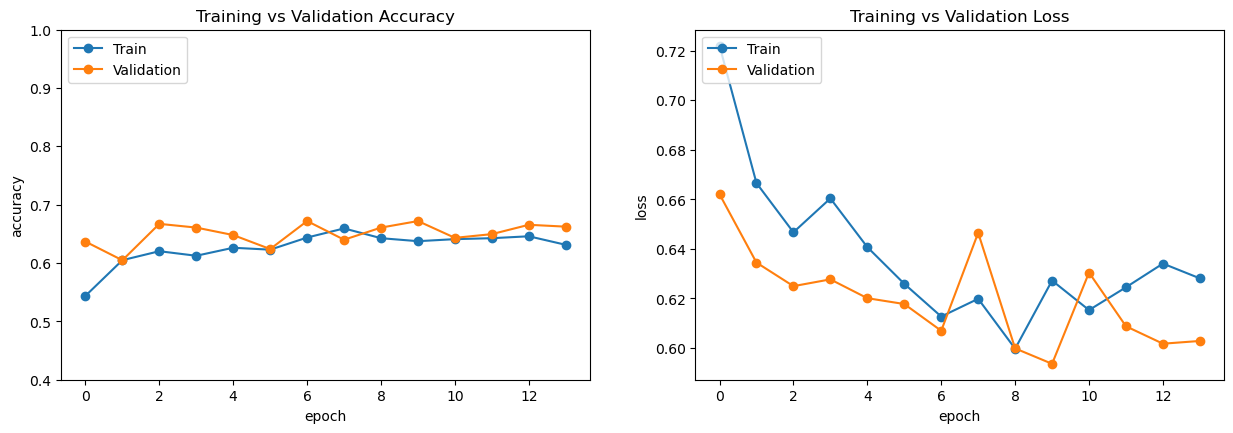

In [45]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy", marker="o")
plt.plot(val_accuracy, label = "Validation Accuracy", marker="o")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss", marker="o")
plt.plot(val_loss, label = "Validation Loss", marker="o")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

In [46]:
model=load_model("/kaggle/working/model.h5")

In [47]:
pred=model.predict(validation_generator)

20/20 [==============================] - 249s 12s/step


In [48]:
pred

array([[0.34122872],
       [0.8489076 ],
       [0.53503454],
       [0.6325688 ],
       [0.4932298 ],
       [0.47542495],
       [0.5073908 ],
       [0.7647241 ],
       [0.18337293],
       [0.74929714],
       [0.591088  ],
       [0.5280406 ],
       [0.5441339 ],
       [0.5669407 ],
       [0.6391685 ],
       [0.85819787],
       [0.85360885],
       [0.59556884],
       [0.6190403 ],
       [0.5895739 ],
       [0.47396743],
       [0.7517062 ],
       [0.8410509 ],
       [0.5304846 ],
       [0.7008669 ],
       [0.6096901 ],
       [0.53658426],
       [0.65627974],
       [0.756628  ],
       [0.54122454],
       [0.85762674],
       [0.6771898 ],
       [0.46666873],
       [0.10500313],
       [0.6352731 ],
       [0.29148847],
       [0.59184355],
       [0.15179369],
       [0.3483666 ],
       [0.26840532],
       [0.68775916],
       [0.22186247],
       [0.63649   ],
       [0.66833633],
       [0.60660094],
       [0.50001806],
       [0.424815  ],
       [0.579

In [49]:
y_pred=[]

for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [50]:
print(y_pred)

[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 

In [51]:
pd.Series(y_pred).value_counts()

1    462
0    163
dtype: int64

In [52]:
y_true=validation_generator.classes
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

# Confusion Matrix
Confusion matrix was created with the predicted and observed values. The matrix indicated almost correct predictions by the trained model except that there were two cases observed as false positive. False positive means that a case is actually negative but predicted as positive.

In [53]:
cm=confusion_matrix(y_true,y_pred)

Text(50.722222222222214, 0.5, 'Truth')

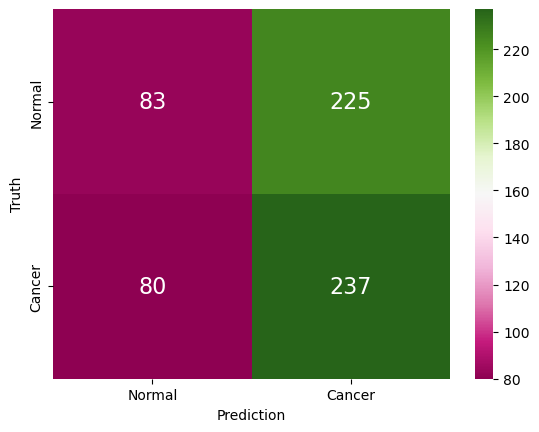

In [54]:
class_names=['Normal','Cancer']

ax=sns.heatmap(cm, annot=True, fmt='.0f', cmap='PiYG', annot_kws={'size':16}, xticklabels=class_names, yticklabels=class_names)


ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')

# Classification Report
Classification report describes precision, recall, and f1-score as to each value. Many people regard accuracy and f1-score as the most important indicator to evaluate an AI model. This may be correct, but is not necessarily correct in the clinical field. It must be considered why AI can be useful for and accepted by healthcare professionals. They expect that AI may be able to reduce their workload. What does it mean to reduce their workload by AI? One idea is to exclude lots of negative cases by AI that healthcare professionals would not have to see in order that they would be able to concentrate on the remaining positive cases to be treated. Thus, it is required that the AI should be able to exclude negative cases without false negatives, which are actually positive but predicted as negative. Otherwise, they would have to re-check the negative cases in order not to miss actually positive cases. They must absolutely avoid clinical negligence! Therefore, if the AI model does not give rise to false negative cases, the model will be considerably acceptable in the healthcare field regardless of the accuracy or f1-score.

In [55]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.27      0.35       308
           1       0.51      0.75      0.61       317

    accuracy                           0.51       625
   macro avg       0.51      0.51      0.48       625
weighted avg       0.51      0.51      0.48       625



# Analysing Report
It is crucial in the medical field to analyze what kinds of cases were misclassified by the AI model, because medical misdiagnosis must be avoided as much as possible. Thus, it is necessary to identify false positive and false negative cases. Making a data frame and confusion table can visualize the results. As discussed above, false negative cases must be particularly avoided.

In [56]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [57]:
print(confusion)

['TN', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'TN', 'TN', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'TN', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'FP', 'TN', 'TN', 'FP', 'FP', 'FP', 'TN', 'FP', 'FP', 'FP', 'TN

In [58]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table


,Results
0,TN
1,FP
2,FP
3,FP
4,TN
...,...
620,TP
621,FN
622,TP
623,FN


In [59]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,0,0,TN
1,1,0,FP
2,1,0,FP
3,1,0,FP
4,0,0,TN
...,...,...,...
620,1,1,TP
621,0,1,FN
622,1,1,TP
623,0,1,FN


In [60]:
confusion_table.Results == 'FP'


0      False
1       True
2       True
3       True
4      False
       ...  
620    False
621    False
622    False
623    False
624    False
Name: Results, Length: 625, dtype: bool

In [61]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
1,1,0,FP
2,1,0,FP
3,1,0,FP
6,1,0,FP
7,1,0,FP
...,...,...,...
303,1,0,FP
304,1,0,FP
305,1,0,FP
306,1,0,FP


In [62]:
FPs.index


Int64Index([  1,   2,   3,   6,   7,   9,  10,  11,  12,  13,
            ...
            297, 299, 300, 301, 302, 303, 304, 305, 306, 307],
           dtype='int64', length=225)

In [63]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
308,0,1,FN
312,0,1,FN
317,0,1,FN
323,0,1,FN
328,0,1,FN
...,...,...,...
614,0,1,FN
615,0,1,FN
621,0,1,FN
623,0,1,FN


In [64]:
FNs.index


Int64Index([308, 312, 317, 323, 328, 331, 337, 343, 345, 348, 350, 352, 353,
            359, 361, 363, 370, 371, 372, 375, 376, 386, 390, 391, 393, 395,
            396, 399, 400, 403, 408, 417, 420, 429, 438, 442, 443, 449, 450,
            455, 456, 459, 462, 464, 467, 471, 484, 485, 487, 489, 492, 504,
            505, 509, 511, 515, 527, 531, 533, 550, 555, 560, 561, 564, 565,
            566, 569, 573, 576, 578, 580, 587, 597, 602, 607, 614, 615, 621,
            623, 624],
           dtype='int64')

# Misclassficiation Cases
Identifying and analyzing cases where artificial intelligence (AI) has made erroneous judgments is a critical step towards improving the accuracy and reliability of the system. By identifying the specific instances where the AI has made mistakes and examining the reasons behind these errors, it becomes possible to identify weaknesses in the AI's decision-making process and take appropriate measures to rectify them.

This process of analyzing incorrect judgments made by AI involves careful examination of the input data, as well as an understanding of the specific algorithms and models used by the AI. It may involve techniques such as error analysis, visual inspection of data, and deep dives into the underlying logic and decision-making processes of the AI.

Overall, the analysis of incorrect judgments made by AI is a crucial component of the ongoing efforts to improve the performance and reliability of AI systems. By carefully studying these cases and implementing appropriate improvements, it is possible to create more accurate and effective AI tools that can better serve a wide range of applications and use cases.

In [65]:
import glob
val_images = glob.glob('/kaggle/working/val/*/*.png')

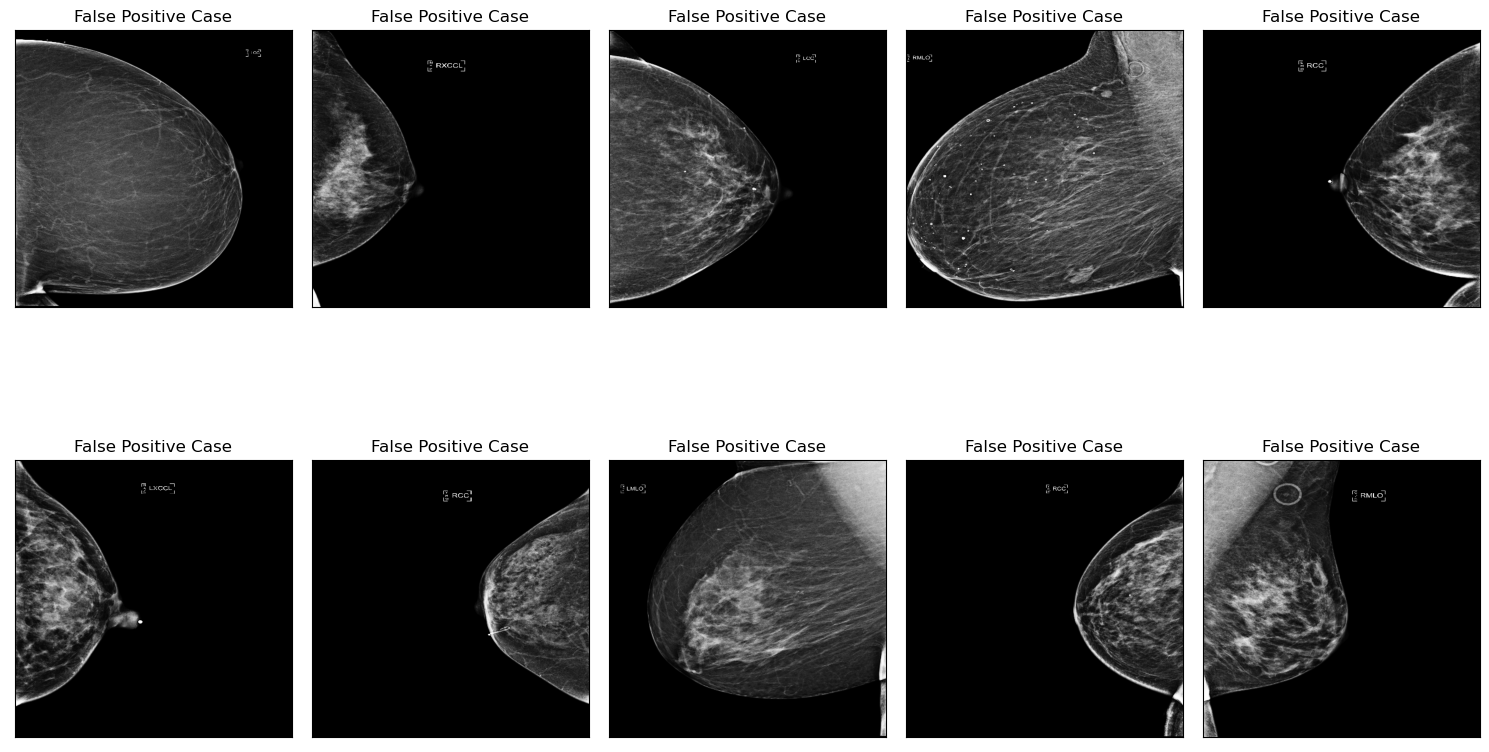

In [66]:
'False positive imgages'
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

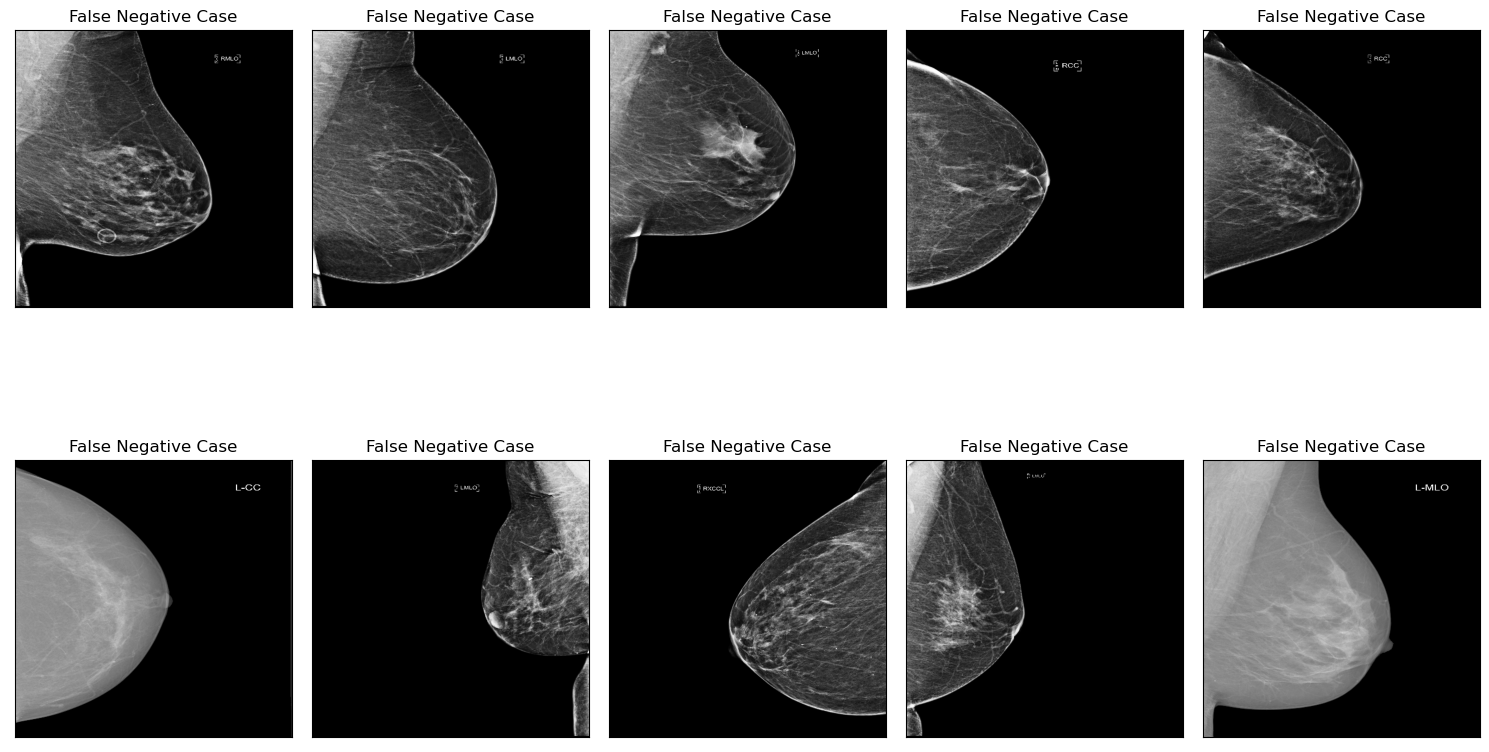

In [67]:
'False negative imgages'
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip(FNs.index, axes.flat):
    img = cv2.imread(val_images[i])
    ax.imshow(img)
    ax.set_title("False Negative Case")
fig.tight_layout()    

plt.show()

# Finetuning the Model (Unfreeying the Layers of the Model)

In [68]:
base_model = ResNet50V2(weights = 'imagenet', input_shape = (512, 512, 3), include_top = False)


'OUR CHANGE IS HERE. FALSE TO TRUE.'
for layer in base_model.layers:
    layer.trainable = True 
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

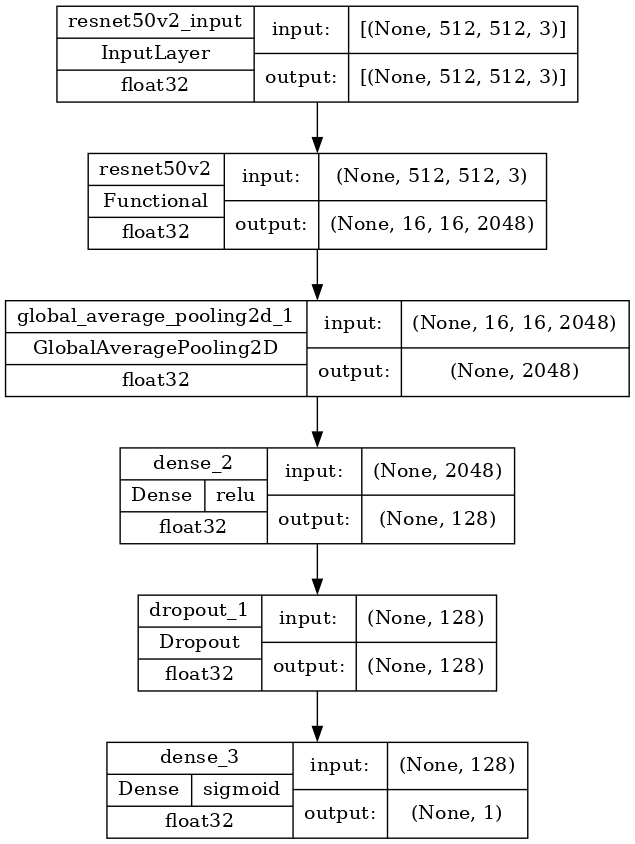

In [69]:
plot_model(model, show_dtype=True, show_layer_activations=True, show_shapes=True, show_layer_names=True,
          to_file='model_finetune.png', dpi=100)


In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 16, 16, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_____________________________________

In [71]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history=model.fit(train_generator,
                 validation_data=validation_generator,
                 steps_per_epoch=20,
                 epochs=40,
                 verbose=0,
                 callbacks=[callback, TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [72]:
'This time we use validation data to calculate the final accuracy.'
final_accuracy = model.evaluate_generator(validation_generator)[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [73]:
final_accuracy


0.5983999967575073

In [74]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

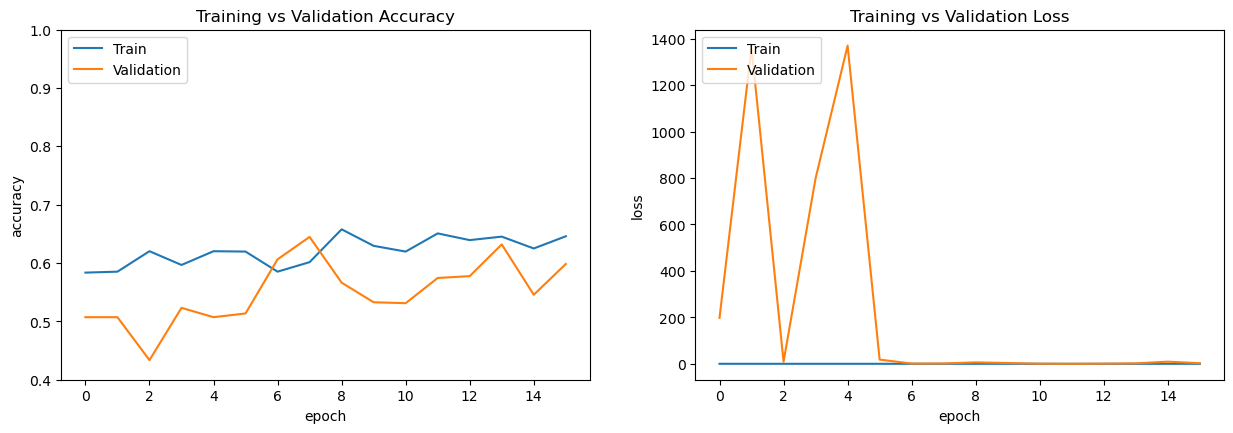

In [75]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

**Finetuning is worse than Transfer Learning, because the number of data images is small!
**

# Conclusion
This AI model may be useful for general physicians who occasionally see female patients for the screening purpose. Further improvement is required to prevent misdiagnosis and unnecessary treatment.